In [69]:
!export CUDA_LAUNCH_BLOCKING=1
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision
import torch
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import time 
import os
import h5py
from tqdm import tqdm_notebook

In [70]:
from torch.utils.data import Dataset
import resource
soft, hard = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (hard, hard))

In [71]:
from PIL import Image
import glob

In [72]:
img = 0
pix = 0



(32, 32, 3)
(21551,)


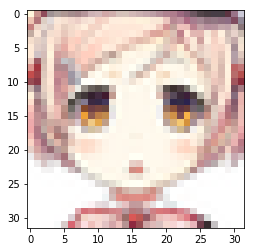

In [73]:
anime_data_face = []
for file in glob.glob("anime_faces/*"):
    img = Image.open(file)
    img = img.resize((32,32),Image.ANTIALIAS)
    pix = np.asarray(img)
    anime_data_face.append(pix)


In [74]:
al = len(anime_data_face)
anime_y = np.ones(al)
al

21551

(32, 32, 3)

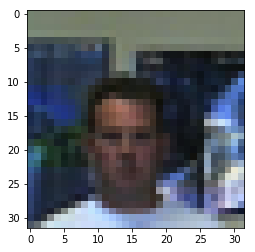

In [75]:
faces_data = []
for file in glob.glob("people_faces/*"): 
    img = Image.open(file)
    img = img.resize((32,32),Image.ANTIALIAS)
    pix = np.asarray(img)
    faces_data.append(pix)
plt.imshow(pix)
pix.shape

In [ ]:
test_data = []

img = Image.open(file)
img = img.resize((32,32),Image.ANTIALIAS)
pix = np.asarray(img)


In [76]:
pl = len(faces_data)
people_y = np.zeros(pl)
pl

7864

In [77]:
len(faces_data)

7864

In [78]:
X = faces_data + anime_data_face
X = np.array(X)
X = X.swapaxes(1,3).swapaxes(2,3)
X = X.astype('float32')/255
y = np.append(people_y, anime_y)
y = y.astype(int)

In [79]:
class ImagesDataset(Dataset):
    """The training table dataset.
    """
    def __init__(self, X, y):
        self.len = len(y)
        
        self.x_data = torch.from_numpy(X)
        self.y_data = y 
        
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
        
    def __len__(self):
        return self.len

In [80]:
dataset = ImagesDataset(X, y)


In [81]:
n_train = int(len(y))
n_val = int(len(y) - n_train)
(n_train, n_val)

(23532, 5883)

In [82]:
train_dataset = torch.utils.data.random_split(dataset, [n_train, n_val])


In [83]:
tr_dataset = torch.utils.data.DataLoader(
                   train_dataset,
                   batch_size=128,
                   shuffle=True
               )
vl_dataset = torch.utils.data.DataLoader(
                   val_dataset,
                   batch_size=128,
               )

In [52]:
from IPython.display import clear_output
train_log = []
val_log = []

In [53]:
criterion = F.cross_entropy

In [54]:
def train(dataset, model, optimizer):
    model.train()
    t = time.time()
    total_loss = 0
    correct = 0
    for X, target in tqdm_notebook(dataset):
        X = torch.FloatTensor(X).cuda()
        output = model(X)
        loss = criterion(output, torch.LongTensor(target).cuda())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss
        y_hat = output.argmax(-1)
        c = (target.cpu() == y_hat.cpu()).sum()
        correct += c
    model.total_epoch += 1

    total_loss /= len(dataset)
    print('epochs = %d' % model.total_epoch, 'loss = %.3f' % total_loss, 'accuracy = %f' % (float(correct) / len(train_dataset)), 'time = %.2f' % (time.time() - t))

    return total_loss

In [55]:
def validate(dataset, count, model):
    model.eval()
    t = time.time()
    correct = 0
    for X, target in tqdm_notebook(dataset):
        X = torch.FloatTensor(X).cuda()
        output = model(X)
        y_hat = output.argmax(-1)
        c = (target.cpu() == y_hat.cpu()).sum()
        correct += c

    print('epochs = %d' % model.total_epoch, 'accuracy = %f' % (float(correct) / count), 'time = %.2f' % (time.time() - t))

In [56]:
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model_class, path, args=[], kwargs={}):
    model = model_class().cuda(*args, **kwargs)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [57]:
class LinearBase(nn.Module):
    def __init__(self):
        super(LinearBase, self).__init__()
        
        in_dim, out_dim = 3072, 2
        layer1_out = 3000
        layer2_out = 2000
        layer3_out = 1000
        self.total_epoch = 0
        self.tr = nn.Sequential(
            nn.Linear(in_dim, layer1_out),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(layer1_out),
            nn.Linear(layer1_out, layer2_out),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(layer2_out),
            nn.Linear(layer2_out, layer3_out),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(layer3_out),
            nn.Linear(layer3_out, out_dim),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.tr(x)
        return x


model = LinearBase().cuda()
#model = load_model(LinearBase, 'linear_model')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)

In [58]:
for epoch in tqdm_notebook(range(5)):
    train(tr_dataset, model, optimizer)

epochs = 1 loss = 0.068 accuracy = 0.990991 time = 4.12


epochs = 2 loss = 0.008 accuracy = 0.998640 time = 3.95


epochs = 3 loss = 0.003 accuracy = 0.999490 time = 3.97


epochs = 4 loss = 0.002 accuracy = 0.999660 time = 4.03


epochs = 5 loss = 0.004 accuracy = 0.999065 time = 4.00


epochs = 6 loss = 0.003 accuracy = 0.999363 time = 4.05


epochs = 7 loss = 0.002 accuracy = 0.999490 time = 4.02


epochs = 8 loss = 0.001 accuracy = 0.999618 time = 4.00


epochs = 9 loss = 0.001 accuracy = 0.999575 time = 4.03


epochs = 10 loss = 0.002 accuracy = 0.999575 time = 3.99



In [59]:
print("Train: ", end='')
validate(tr_dataset, len(train_dataset), model)
print("Test: ", end='')
validate(vl_dataset, len(val_dataset), model)

Train: 


epochs = 10 accuracy = 0.999958 time = 1.30
Test: 


epochs = 10 accuracy = 0.999490 time = 0.33


In [60]:
save_model(model, 'linear_model')

In [63]:
class VGGBase(nn.Module):
    def __init__(self):
        super(VGGBase, self).__init__()
        
        num_classes = 2
        in_dim, out_dim = 3, 1024
        layer1_out = 128
        layer2_out = 256
        layer3_out = 512
        layer4_out = 1024
        self.total_epoch = 0
        self.tr = nn.Sequential(
            # layer 1
            nn.Conv2d(in_dim, layer1_out, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(layer1_out),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # layer 2
            nn.Conv2d(layer1_out, layer2_out, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(layer2_out),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # layer 3
            nn.Conv2d(layer2_out, layer3_out, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(layer3_out),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # layer 4
            nn.Conv2d(layer3_out, layer4_out, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(layer4_out),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # layer 5
            nn.Conv2d(layer4_out, out_dim, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dim),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # linear
        in_lin_dim, out_lin_dim = 1024, 2
        layer1_lin_out = 3000
        layer2_lin_out = 2000
        layer3_lin_out = 1000
        self.classifier = nn.Sequential(
            nn.Linear(in_lin_dim, layer1_lin_out),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(layer1_lin_out),
            nn.Linear(layer1_lin_out, layer2_lin_out),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(layer2_lin_out),
            nn.Linear(layer2_lin_out, layer3_lin_out),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(layer3_lin_out),
            nn.Linear(layer3_lin_out, out_lin_dim),
        )

    def forward(self, x):
        x = self.tr(x)
        
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = VGGBase().cuda()
#model = load_model(VGGBase, 'vgg_base')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,
                             weight_decay=0)

In [64]:
for epoch in tqdm_notebook(range(1, 5)):
    train(tr_dataset, model, optimizer)
    try:
        save_model(model, 'vgg_base_' + str(epoch))
    except Exception as e:
        print(str(e))

epochs = 1 loss = 0.033 accuracy = 0.991416 time = 185.55


epochs = 2 loss = 0.004 accuracy = 0.998980 time = 185.36


epochs = 3 loss = 0.000 accuracy = 0.999915 time = 108.82


epochs = 4 loss = 0.003 accuracy = 0.999278 time = 94.09


In [66]:
print("Train: ", end='')
validate(tr_dataset, len(train_dataset), model)
print("Test: ", end='')
validate(vl_dataset, len(val_dataset), model)

Train: 

epochs = 4 accuracy = 1.000000 time = 12.52
Test: 

epochs = 4 accuracy = 0.999830 time = 3.13


In [67]:
save_model(model, 'vgg_base')

torch.Size([128, 3, 32, 32])
true 1.0
pred 1.0
probability 0.999834
torch.Size([32, 32, 3])


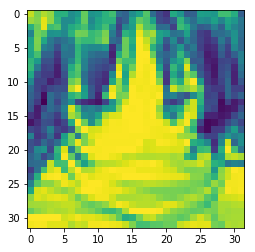

torch.Size([128, 3, 32, 32])
true 1.0
pred 1.0
probability 0.999808
torch.Size([32, 32, 3])


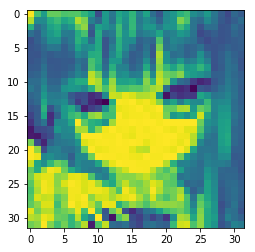

torch.Size([128, 3, 32, 32])
true 1.0
pred 1.0
probability 0.999846
torch.Size([32, 32, 3])


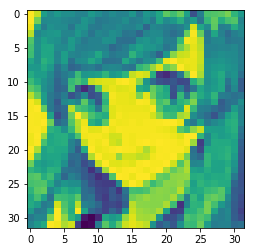

torch.Size([128, 3, 32, 32])
true 1.0
pred 1.0
probability 0.999865
torch.Size([32, 32, 3])


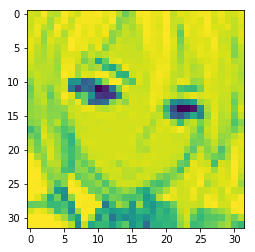

torch.Size([128, 3, 32, 32])
true 1.0
pred 1.0
probability 0.999864
torch.Size([32, 32, 3])


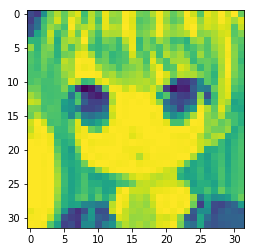

torch.Size([128, 3, 32, 32])
true 0.0
pred 0.0
probability 1.33267e-06
torch.Size([32, 32, 3])


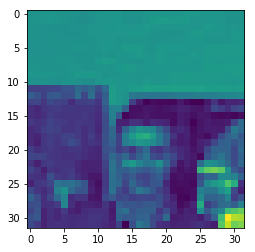

torch.Size([128, 3, 32, 32])
true 0.0
pred 0.0
probability 1.88277e-05
torch.Size([32, 32, 3])


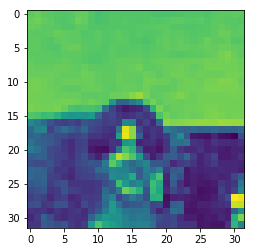

torch.Size([128, 3, 32, 32])
true 0.0
pred 0.0
probability 6.80761e-09
torch.Size([32, 32, 3])


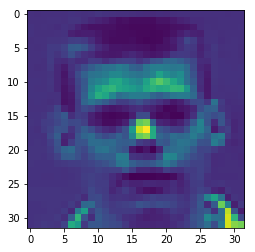

torch.Size([128, 3, 32, 32])
true 0.0
pred 0.0
probability 4.13998e-11
torch.Size([32, 32, 3])


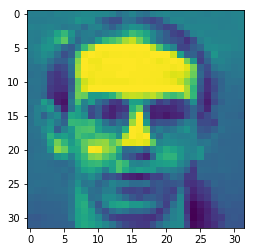

torch.Size([128, 3, 32, 32])
true 1.0
pred 1.0
probability 0.999904
torch.Size([32, 32, 3])


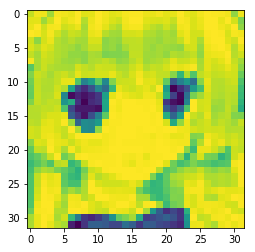

torch.Size([128, 3, 32, 32])
true 0.0
pred 0.0
probability 2.83355e-08
torch.Size([32, 32, 3])


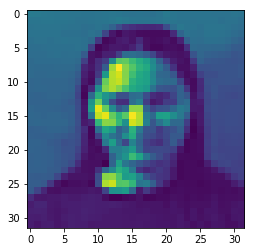

torch.Size([128, 3, 32, 32])
true 0.0
pred 0.0
probability 4.16254e-07
torch.Size([32, 32, 3])


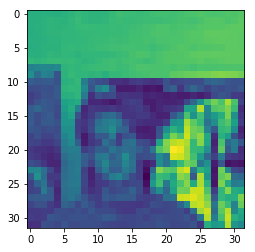

torch.Size([128, 3, 32, 32])
true 1.0
pred 1.0
probability 0.999821
torch.Size([32, 32, 3])


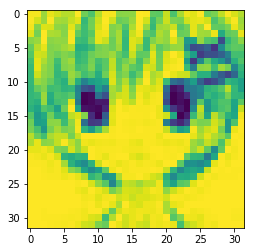

torch.Size([128, 3, 32, 32])
true 0.0
pred 0.0
probability 4.49928e-15
torch.Size([32, 32, 3])


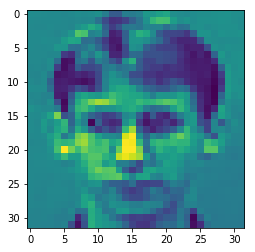

torch.Size([128, 3, 32, 32])
true 1.0
pred 1.0
probability 0.999847
torch.Size([32, 32, 3])


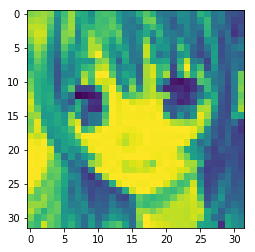

torch.Size([128, 3, 32, 32])
true 1.0
pred 1.0
probability 0.999885
torch.Size([32, 32, 3])


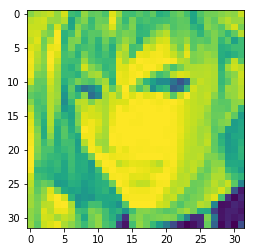

torch.Size([128, 3, 32, 32])
true 1.0
pred 1.0
probability 0.999793
torch.Size([32, 32, 3])


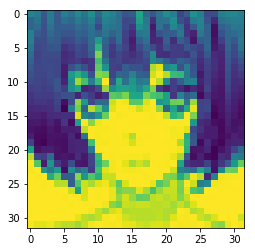

torch.Size([128, 3, 32, 32])
true 1.0
pred 1.0
probability 0.999852
torch.Size([32, 32, 3])


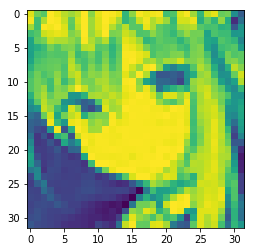

torch.Size([128, 3, 32, 32])
true 1.0
pred 1.0
probability 0.999885
torch.Size([32, 32, 3])


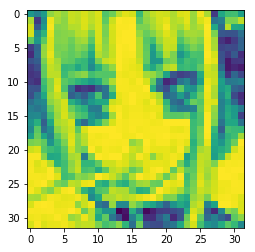

torch.Size([128, 3, 32, 32])
true 1.0
pred 1.0
probability 0.999856
torch.Size([32, 32, 3])


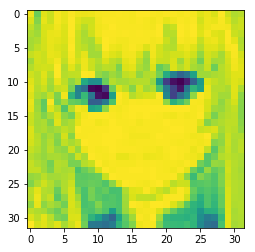

torch.Size([128, 3, 32, 32])
true 1.0
pred 1.0
probability 0.999879
torch.Size([32, 32, 3])


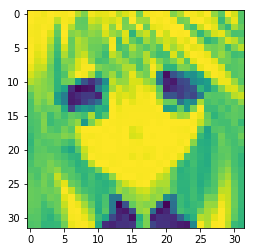

torch.Size([128, 3, 32, 32])
true 0.0
pred 0.0
probability 4.96812e-08
torch.Size([32, 32, 3])


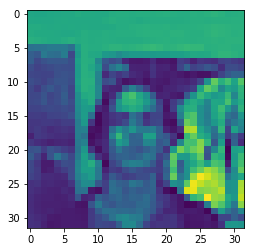

torch.Size([128, 3, 32, 32])
true 0.0
pred 0.0
probability 1.37357e-11
torch.Size([32, 32, 3])


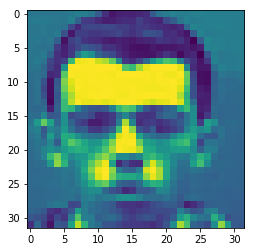

torch.Size([128, 3, 32, 32])
true 1.0
pred 1.0
probability 0.999837
torch.Size([32, 32, 3])


torch.Size([128, 3, 32, 32])
true 0.0
pred 0.0
probability 5.56581e-10
torch.Size([32, 32, 3])


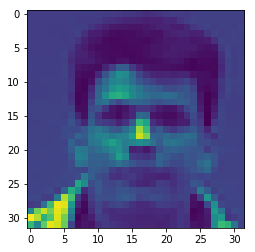

torch.Size([128, 3, 32, 32])
true 1.0
pred 1.0
probability 0.999801
torch.Size([32, 32, 3])


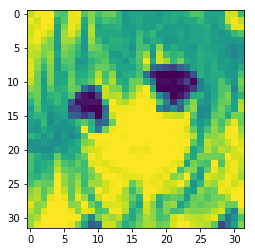

torch.Size([128, 3, 32, 32])
true 1.0
pred 1.0
probability 0.99982
torch.Size([32, 32, 3])


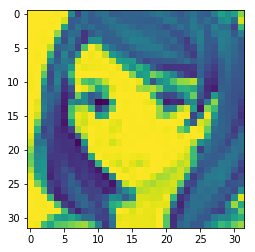

torch.Size([128, 3, 32, 32])
true 1.0
pred 1.0
probability 0.999864
torch.Size([32, 32, 3])


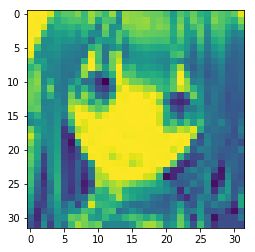

torch.Size([128, 3, 32, 32])
true 0.0
pred 0.0
probability 2.41853e-12
torch.Size([32, 32, 3])


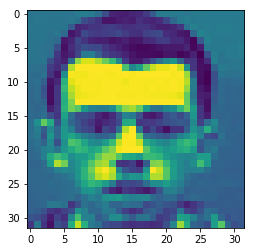

torch.Size([128, 3, 32, 32])
true 1.0
pred 1.0
probability 0.99986
torch.Size([32, 32, 3])


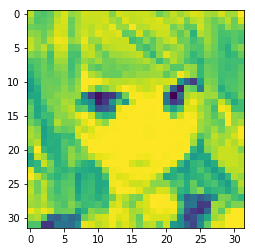

torch.Size([128, 3, 32, 32])
true 0.0
pred 0.0
probability 1.04766e-07
torch.Size([32, 32, 3])


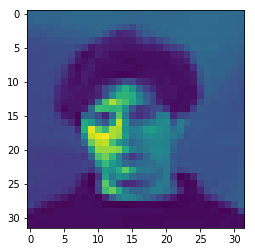

torch.Size([128, 3, 32, 32])
true 1.0
pred 1.0
probability 0.999843
torch.Size([32, 32, 3])


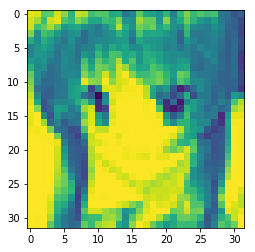

In [87]:
for i, (X, y) in enumerate(vl_dataset):
    print(X.shape)
    X = X[:1].cuda()

    logits  = model(X)
    probs = F.softmax(logits, dim=1)

    print('true', float(y[0]))
    print('pred', float(logits.argmax(-1)[0]))
    
    print('probability', probs.detach().cpu().numpy()[0][1])
    
    print(X.reshape(32, 32, -1).shape)
    
    plt.imshow(X.cpu().reshape(-1, 32, 32)[0])
    plt.show()
    
    if i>30:
        break

In [86]:
probs.detach().cpu().numpy()

array([[  1.65685778e-04,   9.99834299e-01]], dtype=float32)

1 - anime

0 - people

In [ ]:
# Predictions for avatars

In [88]:
avatars_array = []

file = glob.glob('avatars/*')[0]
img = Image.open(file)
img = img.resize((weight,height),Image.ANTIALIAS)
pix = np.asarray(img)
avatars_array.append(pix)

#os.remove(file)

NameError: name 'weight' is not defined

In [ ]:
plt.imshow(img)
pix.shape

In [89]:
X_test = np.array(avatars_array)
X_test = X_test.swapaxes(1,3).swapaxes(2,3)
X_test = X_test.astype('float32')/255
len(X_test)

ValueError: bad axis1 argument to swapaxes

In [90]:
class TestDataset(Dataset):
        
    def __init__(self, X_test):

        self.len = len(X_test)        
        self.x_data = torch.from_numpy(X_test)
        
    def __getitem__(self, index):
        return self.x_data[index], 0
        
    def __len__(self):
        return self.len

In [91]:
test = TestDataset(X_test)

In [92]:
test_dataset = torch.utils.data.DataLoader(
                   test,
                   batch_size=1,
               )

In [95]:
for i, (X, y) in enumerate(test_dataset):
    print(X.shape)
    X = X[:1].cuda()

    logits  = model(X)
    probs = F.softmax(logits, dim=1)

    print('pred', float(logits.argmax(-1)[0]))
    
    print('probs 0 1', probs.detach().cpu().numpy())
    
    print(X.reshape(32, 32, -1).shape)
    
    plt.imshow(X.cpu().reshape(-1, 32, 32)[0])
    plt.show()